# Aprendizaje no supervisado

José Luis Ruiz Reina <br>
Miguel A. Gutiérrez Naranjo

Versión del 15 de enero de 2024

## Clustering: aplicaciones

Los ejemplos y la discusión que sigue está parcialmente tomado del libro:

[*Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow*](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)  
**Aurélien Géron**  
O'Reilly 2019

En concreto, este tema está basado en el capítulo 9, pero con modificaciones. En lo que sigue, abreviaremos el libro como *handson-ml*. 

Github con el material del libro: [Github](https://github.com/ageron/handson-ml2). 

#### Configuración (ver Github del Cap. 9 del libro)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Guardando la figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Veamos a continuación algunas aplicaciones de los algoritmos de clustering. En concreto:

* Segmentación de imágenes
* Preprocesado
* Aprendizaje semi-supervisado

Aunque en lo que sigue aplicaremos k-medias, podríamos también hacerlo con otros algoritmos de clustering.

In [2]:
from sklearn.cluster import KMeans

### Segmentación de imágenes

Aunque en el procesamiento de imágenes hay muchos tipos de segmentación, vamos a ver aquí un uso muy simple de clustering para hacer segmentación por colores de una imagen. Se asigna cada píxel  a un  cluster, de manera que los píxeles se agrupen por similitud de colores. De esta manera, también podemos representar una imagen con una paleta reducida de colores (al coste de perder definición) asignando el mismo color a todos los píxeles que pertenezcan al mismo cluster.

Vamos en primer lugar a descargar una imagen que usaremos como muestra.

In [3]:
# Descargar la foto de la mariquita (ladybug) 
import urllib
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Descargando", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

Descargando ladybug.png


('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x2851eca8910>)

Con la utilidad `imread` de matplotlib, leemos la imagen y la pasamos un un array 3D :

In [5]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))

Podemos incluso usar este array para visulaizar la imagen, usando para ello la utilidad `imshow`:

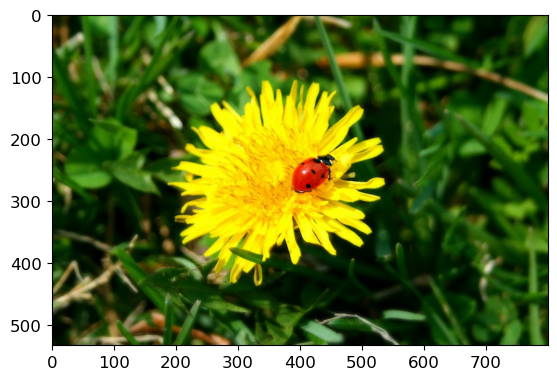

In [6]:
from matplotlib.pyplot import imshow
imshow(image)

Analizando el array `image` con más detalle, la imagen tiene 533x800 píxeles (alto x ancho) y cada pixel está representado por una terna que representa los tres canales de color (RGB). Nótese que los valores ya están normalizados.

In [7]:
image.shape

(533, 800, 3)

In [8]:
image

array([[[0.09803922, 0.11372549, 0.00784314],
        [0.09411765, 0.10980392, 0.00392157],
        [0.09411765, 0.11372549, 0.        ],
        ...,
        [0.22352941, 0.4117647 , 0.08235294],
        [0.21960784, 0.40392157, 0.08627451],
        [0.20392157, 0.3882353 , 0.07450981]],

       [[0.09411765, 0.10980392, 0.00392157],
        [0.09019608, 0.10588235, 0.        ],
        [0.09019608, 0.10588235, 0.        ],
        ...,
        [0.23529412, 0.42352942, 0.08627451],
        [0.23137255, 0.41568628, 0.09803922],
        [0.21568628, 0.4       , 0.08627451]],

       [[0.09019608, 0.10588235, 0.00784314],
        [0.08627451, 0.10196079, 0.00392157],
        [0.08627451, 0.10196079, 0.        ],
        ...,
        [0.25882354, 0.44705883, 0.10980392],
        [0.24705882, 0.43529412, 0.10588235],
        [0.22745098, 0.4117647 , 0.09411765]],

       ...,

       [[0.05490196, 0.07058824, 0.00392157],
        [0.05490196, 0.07058824, 0.00392157],
        [0.05098039, 0

Para hacer la segmentación de colores, primero vamos a representar la imagen como una lista de píxeles, representando cada píxel con su correspondiente terna RGB.

In [15]:
X_ladybug = image.reshape(-1, 3)

In [16]:
X_ladybug[:10]

array([[0.09803922, 0.11372549, 0.00784314],
       [0.09411765, 0.10980392, 0.00392157],
       [0.09411765, 0.11372549, 0.        ],
       [0.10196079, 0.11372549, 0.        ],
       [0.09803922, 0.11372549, 0.00784314],
       [0.09411765, 0.10980392, 0.00392157],
       [0.08235294, 0.10588235, 0.00392157],
       [0.0627451 , 0.10196079, 0.00392157],
       [0.05098039, 0.09803922, 0.00392157],
       [0.05098039, 0.10588235, 0.00784314]], dtype=float32)

In [17]:
X_ladybug.shape

(426400, 3)

La idea ahora es sencilla: 
* Aplicamos un algoritmo de clustering a ese array, en el que el número de grupos será el número de colores en el que se quiere segmentar la imagen. 
* Sustituimos cada píxel por el centro del clúster que se le ha asignado
* Volvemos a reestructurar la imagen como un array 3D

Por ejemplo, segmentando con 10 colores. En primer lugar realizamos un k-medias con un número de grupos igual al número de colores que queremos usar. 

In [18]:
kmeans_ladybug = KMeans(n_clusters=10, random_state=42).fit(X_ladybug)

Los clusters asignados a cada pixel están en `labels_`:

In [19]:
kmeans_ladybug.labels_

array([4, 4, 4, ..., 2, 2, 2])

Los centros calculados los tenemos en `cluster_centers`, y serían los colores representativos de cada cluster (específicamente, su valor RGB): 

In [20]:
kmeans_ladybug.cluster_centers_

array([[0.2609577 , 0.42417416, 0.07926214],
       [0.9074826 , 0.7447091 , 0.03023737],
       [0.06765619, 0.21060258, 0.01114132],
       [0.5415263 , 0.49436086, 0.16621357],
       [0.01683912, 0.09344557, 0.00513392],
       [0.3519834 , 0.5596916 , 0.17916825],
       [0.9843901 , 0.9423837 , 0.0261706 ],
       [0.80480707, 0.1612719 , 0.03961181],
       [0.63018036, 0.6565    , 0.42595088],
       [0.15598756, 0.3211429 , 0.03080294]], dtype=float32)

In [21]:
segmented_img = kmeans_ladybug.cluster_centers_[kmeans_ladybug.labels_]
segmented_img = segmented_img.reshape(image.shape)

Mostremos ahora la imagen segmentada:

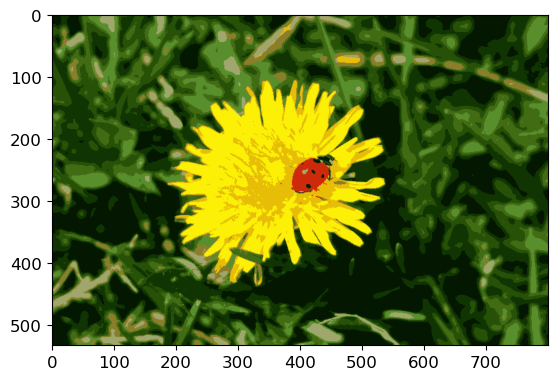

In [22]:
imshow(segmented_img)

A continuación se muestran distintas variantes con menos colores:

Guardando la figura image_segmentation_diagram


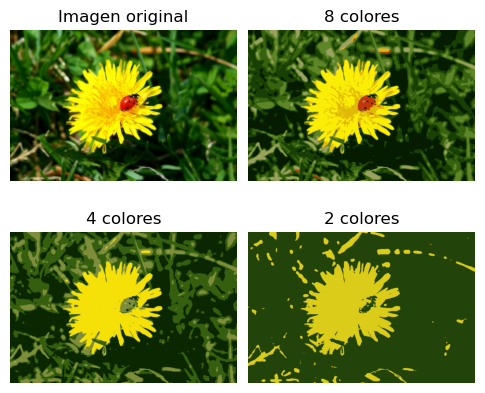

In [23]:
segmented_imgs = []
n_colors = (8, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_ladybug)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
    
plt.figure(figsize=(6,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(221)
plt.imshow(image)
plt.title("Imagen original")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(222 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colores".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()   

Como se observa, con 4 colores o menos ya la mariquita no tiene un color distintivo, puesto que los píxeles correspondiente se asignan al mismo clúster (tono de verde) que otras zonas de la imagen. La razón es que el conjunto de píxeles de la mariquita es muy pequeño, con lo que k-medias no le asigna un cúster propio.   

### Preprocesado

Otra de las aplicaciones sencillas e interesantes de los algoritmos de clustering es su uso como herramienta para realizar un preprocesado previo a un clasificador, en concreto para reducir la dimensionalidad.  

Veamos cómo aplicarlo a un conjunto de dígitos escritos a mano. Para ello vamos a tomar el dataset de dígitos proporcionado por scikit learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

In [24]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [25]:
X_train.shape

(1347, 64)

Para tomarlo como base, veamos por ejemplo el comportamiento de un clasificador mediante regresión logística:

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

La idea ahora es usar k-medias, y su método `transform`, para una vez aplicado el algoritmo de clustering, transformar cada imagen en un vector k-dimensional, en el que las k componentes son las distancias a los k centros. Y una vez realizada la transformación, aplicar el clasificador. 

Esta es la típica tarea de composición de procedimientos que se hace de manera muy cómoda mediante `Pipeline`, obteniendo un clasificador que podemos entrenar sobre el conjuto de dígitos. Recuérdese que en un pipeline, los pasos previos al último realizan `fit_transform` y pasan el resultado al siguiente paso. Recuérdese también que el método `transform` de `KMeans` transforma cada instancia al vector de sus distancias a los centros (es decir, el preprocesado que se ha comentado más arriba).  

In [29]:
from sklearn.pipeline import Pipeline

In [30]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

Nótese que hemos elegido usar 50 clústeres. Puesto que son 10 dígitos posibles, podría pensarse que 10 es un número más adecuado, pero en realidad el mismo dígito puede escribirse de maneras distintas. 

Veamos el rendimiento obtenido y la mejora proporcional de ese rendimiento respecto del que se obtenía usando sólamente el clasificador, sin preprocesar.

In [31]:
pipeline_score = pipeline.score(X_test, y_test)
print("Rendimiento: ",pipeline_score)
print("Mejora :", 1 - (1 - pipeline_score) / (1 - log_reg_score))

Rendimiento:  0.9777777777777777
Mejora : 0.28571428571428414


Como se ve, hemos obtenido una mejora casi del 30%. El elegir 50 clústeres ha sido bastante arbitrario, por lo que podríamos usar ahora `GridSearchCV` para realizar un ajuste de ese parámetro Puede tardar):

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = dict(kmeans__n_clusters=range(2, 100,10)) # Podemos fijar los centros que queramos
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.4s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.4s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.4s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   0.9s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   0.9s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   0.9s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   2.0s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   1.8s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   1.8s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   2.2s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   2.1s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   2.2s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   2.6s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   2.7s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=42; total time=   2.6s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   2.7s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   2.9s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=52; total time=   3.0s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   3.1s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   3.2s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=62; total time=   2.9s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   3.3s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   3.2s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=72; total time=   3.2s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   3.2s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   3.4s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=82; total time=   3.5s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   3.4s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   3.1s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=92; total time=   3.1s


C:\Users\diego\anaconda3\envs\robotica\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100, 10)}, verbose=2)

Podemos ver cuál ha sido el mejor parámetro encontrado para `n_clusters` y su rendimiento: 

In [34]:
grid_clf.best_params_

{'kmeans__n_clusters': 82}

In [35]:
grid_clf.score(X_test, y_test)

0.98

### Aprendizaje semisupervisado

Supongamos que tenemos un conjunto de datos en el que solo una pequeña parte está etiquetada con su valor de clasificación. Es decir, estamos ante una tarea de aprendizaje *semi-supervisado*. 

Evidentemente, el rendimiento con menos datos de los cuales conocemos su valor de clasificación se resiente. Veamos por ejemplo si entrenamos un clasificador de regresión logística con sólo las primeras 50 imágenes de la base de datos de números escritos a mano:

In [36]:
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

No es sorprendente que obtengamos un rendimiento bastante inferior a cuando fue entrenado con todo el conjunto de entrenamiento. Pero veamos cómo utilizando clustering como herramienta, podemos conseguir mejores resultados con solo 50 instancias.  

La idea es hacer clustering con $k=50$, y luego, para cada centro, nos quedaremos con la instancia más cercana (lo que llamaremos *imagen representativa*). Posteriormente etiquetaremos manualmente las imágenes representativas. 

In [29]:
k=50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)               # distancia de cada imagen a cada centro
representative_digit_idx = np.argmin(X_digits_dist, axis=0) # para cada centro, la posición 
                                                            # de la imagen más cercana (representativa)
X_representative_digits = X_train[representative_digit_idx] # array con las imágenes representativas

Supongamos que no tenemos las etiquetas de estas imágenes representativas. Por tanto, vamos a visualizarlas y a crear las etiquetas manualmente:

Guardando la figura representative_images_diagram


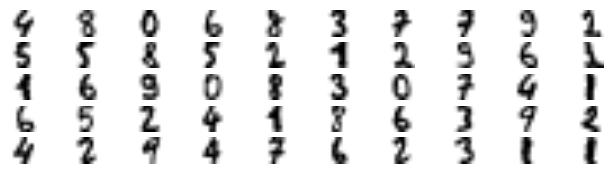

In [30]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [31]:
y_representative_digits = np.array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 
                                    5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 
                                    1, 6, 9, 0, 8, 3, 0, 7, 4, 1, 
                                    6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 
                                    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Nótese el considerable aumento en el rendimiento si usamos estas imágenes representativas como conjunto de entrenamiento para el clasificador:

In [32]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=1000,random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Veamos ahora qué pasa si usamos todos los datos, pero *propagando* el valor de clasificación desde las imágenes representativas, a las que están en el mismo clúster:

In [33]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):   # en cada cluster asignamos la clase del correspondiente representativo
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [34]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

Hemos aumentado el rendimiento, pero quizás podríamos afinar un poco más, a costa de descartar algunas instancias. La idea es que sólo vamos a propagar la clasificación desde las imágenes representativas, al 75% de las que están más cercanas a ellas:

In [35]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_] # distancia al centro más cercano
for i in range(k):     # Para cada clúster
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster] # distancias dentro de ese grupo
    cutoff_distance = np.percentile(cluster_dist, percentile_closest) # percentil
    above_cutoff = (X_cluster_dist > cutoff_distance) # las que quedan fuera del percentil las ponemos a -1
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1) 
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]


In [36]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9355555555555556

Hemos mejorado un poco. La razón general de estas mejoras es que las etiquetas que se han  propagado son correctas en un muy alto porcentaje, como se puede observar:

In [37]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811